# Downloading the data
The data is from https://www.nasdaqomxnordic.com

In [208]:
import pandas as pd

column_order = ['Date', 'Bid', 'Ask', 'Opening price', 'High price', 'Low price', 'Closing price', 'Average price', 'Total volume', 'Turnover', 'Trades']
data = pd.read_csv("../../Data/Raw_data/SWED_A-1995-06-09-2023-09-15.csv", sep=";", decimal=",", skiprows=1, usecols=column_order)
pd.options.mode.chained_assignment = None  # default='warn'

## Cleaning of data
Changing the index of the rows.

<Axes: xlabel='Date'>

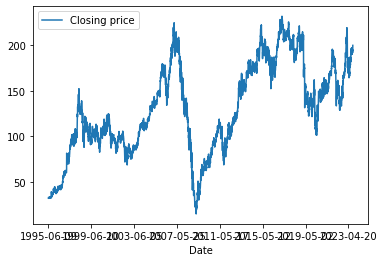

In [209]:
columns_to_drop = ["Bid", "Ask", "Opening price", "Average price"]
data = data.set_index("Date").drop(columns=columns_to_drop)

data = data.dropna(axis=1)

# Change order of rows oldest to newest
data = data[::-1]

data.plot.line(y="Closing price")

### Transform data
make sationary

,Closing price,Trades,Differenced Closing
Date,,,
1995-06-09,32.346,449,NaN
1995-06-12,32.611,448,0.265
1995-06-13,33.407,728,0.796
1995-06-14,32.876,495,-0.531
1995-06-15,33.141,324,0.265
...,...,...,...
2023-09-08,191.500,5274,-0.550
2023-09-11,192.700,4639,1.200
2023-09-12,192.750,4489,0.050


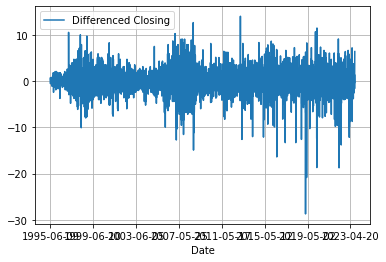

In [210]:
data["Differenced Closing"] = data["Closing price"].diff()
    
data.plot.line(grid=True, y="Differenced Closing")
data

# CHANGE FOR EACH INPUT

,Closing price,Trades,Differenced Closing
Date,,,
1995-06-12,32.611,448,0.265
1995-06-13,33.407,728,0.796
1995-06-14,32.876,495,-0.531
1995-06-15,33.141,324,0.265
1995-06-16,33.141,258,0.000
...,...,...,...
2023-09-08,191.500,5274,-0.550
2023-09-11,192.700,4639,1.200
2023-09-12,192.750,4489,0.050


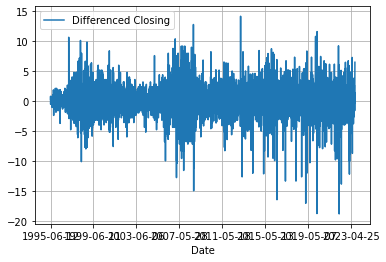

In [211]:
# Set a threshold for drastic price changes
drastic_change_threshold = 20  # You can adjust this threshold based on your data

# Create a boolean mask for rows with drastic price changes
mask = abs(data["Differenced Closing"]) <= drastic_change_threshold

# Apply the mask to filter out rows with drastic changes
data = data[mask]

data.plot.line(grid=True, y="Differenced Closing")
# Display the filtered data
data

## Insert Additional Columns
### Create features

In [212]:
import numpy as np

SHORT_CHANGE_HORIZON = 5
MID_CHANGE_HORIZON = 20
LONG_CHANGE_HORIZON = 50
FACTOR = 0.0155 # Profit to define target 0.014

data["Short_day_change"] = (data["Closing price"] - data["Closing price"].shift(SHORT_CHANGE_HORIZON)) / SHORT_CHANGE_HORIZON
data["Mid_day_change"] = (data["Closing price"] - data["Closing price"].shift(MID_CHANGE_HORIZON)) / MID_CHANGE_HORIZON
data["Long_day_change"] = (data["Closing price"] - data["Closing price"].shift(LONG_CHANGE_HORIZON)) / LONG_CHANGE_HORIZON


data["t+1"] = data["Closing price"].shift(-1)
data["t+2"] = data["Closing price"].shift(-2)
data["t+3"] = data["Closing price"].shift(-3)
data["t+4"] = data["Closing price"].shift(-4)
data["t+5"] = data["Closing price"].shift(-5)

conditions = [
    (data["t+1"] > (data["Closing price"] * (1+FACTOR))) |
    (data["t+2"] > (data["Closing price"] * (1+FACTOR))) |
    (data["t+3"] > (data["Closing price"] * (1+FACTOR))) |
    (data["t+4"] > (data["Closing price"] * (1+FACTOR))) |
    (data["t+5"] > (data["Closing price"] * (1+FACTOR)))
]

choice = [1]
data["Target"] = np.select(conditions, choice, 0)

data = data.dropna()

data["Target"].value_counts()

0    3529
1    3515
Name: Target, dtype: int64

In [213]:
data.tail(20)

,Closing price,Trades,Differenced Closing,Short_day_change,Mid_day_change,Long_day_change,t+1,t+2,t+3,t+4,t+5,Target
Date,,,,,,,,,,,,
2023-08-11,196.70,3901,-0.25,0.92,0.4375,0.613,194.85,192.45,194.00,193.00,191.95,0
2023-08-14,194.85,3940,-1.85,0.38,0.2500,0.496,192.45,194.00,193.00,191.95,191.10,0
2023-08-15,192.45,3740,-2.40,0.32,-0.0450,0.365,194.00,193.00,191.95,191.10,190.35,0
2023-08-16,194.00,5532,1.55,0.17,0.2200,0.396,193.00,191.95,191.10,190.35,189.85,0
2023-08-17,193.00,4458,-1.00,-0.79,0.1400,0.281,191.95,191.10,190.35,189.85,190.30,0
2023-08-18,191.95,4508,-1.05,-0.95,0.0050,0.293,191.10,190.35,189.85,190.30,190.80,0
2023-08-21,191.10,4214,-0.85,-0.75,-0.0825,0.236,190.35,189.85,190.30,190.80,193.45,0
2023-08-22,190.35,3625,-0.75,-0.42,-0.2900,0.267,189.85,190.30,190.80,193.45,194.40,1
2023-08-23,189.85,4060,-0.50,-0.83,-0.2000,0.250,190.30,190.80,193.45,194.40,194.55,1


## Train and test model
- split data

In [214]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def predict(X_train, y_train, X_test, model, threshold):
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:,1]
    
    preds[preds >= threshold] = 1
    preds[preds < threshold] = 0

    return preds


def print_report(pred, y_test, model):

    accuracy = accuracy_score(y_test, pred)
    print(f'Accuracy: {accuracy:.2f}')
    classification_report_str = classification_report(y_test, pred)
    print('Classification Report:\n', classification_report_str)

    # Calculate the AUC (Area Under the ROC Curve)
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve Stationary')
    plt.legend(loc='lower right')
    plt.show()

    

In [215]:
# Does not work yet

def new_backtest(data, model, predictors, start=2500, step=250, threshold=0.6):
    all_predictions = []

    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the model
        X_train = train[predictors].values
        y_train = train["Target"].values
        model.fit(X_train, y_train)

        # Make predictions
        X_test = test[predictors].values
        preds = predict(X_train, y_train, X_test, model, threshold)

        # Combine predictions and test values
        combined = pd.DataFrame({"Date": test.index, "Target": test["Target"], "Predictions": preds})
        all_predictions.append(combined)

    return pd.concat(all_predictions)

Accuracy: 0.54
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.67      0.60       721
           1       0.54      0.41      0.46       688

    accuracy                           0.54      1409
   macro avg       0.54      0.54      0.53      1409
weighted avg       0.54      0.54      0.53      1409



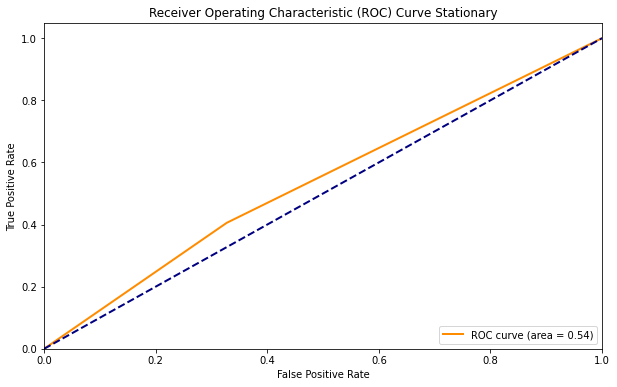

In [216]:
from sklearn.ensemble import RandomForestClassifier

TRAIN_RATIO = 0.8
split_ix = int(len(data) * TRAIN_RATIO)

predictors = ["Differenced Closing", "Short_day_change", "Mid_day_change", "Long_day_change"]

# Split the data into training and testing sets
x = data[["Differenced Closing", "Short_day_change", "Mid_day_change", "Long_day_change"]].values
y = data["Target"].values

X_train, X_test = x[:split_ix], x[split_ix:]
y_train, y_test = y[:split_ix], y[split_ix:]

model = RandomForestClassifier(n_estimators=200, min_samples_split=80, random_state=1)

model.fit(X_train, y_train)

# preds = new_backtest(data=data, model=model, predictors=predictors)

# precision_score(preds["Target"], preds["Predictions"])

y_pred = predict(X_train=X_train, y_train=y_train, X_test=X_test, model=model, threshold=0.55)

print_report(pred=y_pred, y_test=y_test, model=model)

## Back test model

In [217]:
def backtest(data, predictions, initial_cash=10_000):
    
    # s_date = "2020-01-02"

    # # Convert the index of 'data' to Timestamp
    # data.index = pd.to_datetime(data.index)

    # # Convert 's_date' to a datetime object
    # s_date_datetime = pd.to_datetime(s_date)

    # # Slice the 'data' DataFrame starting from 's_date_datetime'
    # data = data[data.index >= s_date_datetime].copy()

    # # Slice 'predictions' to match its length with the shortened 'data'
    # predictions = predictions[len(data) - len(predictions):]
    
    positions = []  # Trading positions: 0 for no action, 1 for buy, -1 for sell
    cash_balance = []  # Cash balance at each time step
    portfolio_value = []  # Portfolio value at each time step

    # Initialize variables for tracking the current position and entry price
    current_position = 0  # 0 for no position, 1 for long (buy), -1 for short (sell)

    for i in range(len(data)):
        
        if i < len(predictions):
            prediction = predictions[i]

            if prediction == 1 and current_position != 1:
                # Buy signal
                current_position = 1  # Set position to long (buy)
                
                positions.append(1)  # Buy signal
                
            elif prediction == 0 and current_position == 1:
                # Sell signal
                current_position = 0  # Set position to no position
                positions.append(-1)  # Sell signal
            else:
                # No action (hold)
                positions.append(0)  # No action (hold)

        else:
            positions.append(0)  # If there's no prediction, stay out of the market

        # Calculate cash balance and portfolio value
        price_change = data['Differenced Closing'].iloc[i]
        if current_position == 1:
            # If in a long position, calculate cash change based on price change
            cash_change = current_position * price_change
        else:
            cash_change = 0  # No cash change if not in a position

        # Update cash balance and portfolio value
        if i == 0:
            cash_balance.append(initial_cash)
        else:
            cash_balance.append(cash_balance[i - 1] + cash_change)
        portfolio_value.append(cash_balance[i] + positions[i] * price_change)

    # Create a DataFrame to store portfolio performance
    return pd.DataFrame({
        'Positions': positions,
        'Price Change': data['Differenced Closing'],
        'Cash': cash_balance,
        'Portfolio Value': portfolio_value
    }, index=data.index)

   
portfolio_data = backtest(data=data, predictions=y_pred, initial_cash=1000)

# plt.figure(figsize=(12, 6))
# plt.plot(portfolio_data.index, portfolio_data['Portfolio Value'], label='Portfolio Value', lw=2)
# plt.xlabel('Date')
# plt.ylabel('Portfolio Value')
# plt.title('Portfolio Value Over Time')
# plt.legend()
# plt.grid(True)
# plt.show()

portfolio_data

,Positions,Price Change,Cash,Portfolio Value
Date,,,,
1995-08-22,0,0.000,1000.000,1000.000
1995-08-23,0,1.061,1000.000,1000.000
1995-08-24,1,0.265,1000.265,1000.530
1995-08-25,-1,0.265,1000.265,1000.000
1995-08-28,0,-0.265,1000.265,1000.265
...,...,...,...,...
2023-09-01,0,-0.050,1226.861,1226.861
2023-09-04,0,-0.350,1226.511,1226.511
2023-09-05,0,1.450,1227.961,1227.961


In [218]:
# Save model
import joblib

joblib.dump(model, "../Prediction/model_RF_SWED.pkl")

['../Prediction/model_RF_SWED.pkl']